In [1]:
from Combined_Data_Raw import *

In [2]:
class mAb_Experiment:
    '''A class which has 3 methods:
        1. Static Method: Predicts the relative Glycan distribution
        2. Dynamic Method: Continuously predicts the Antibody 
                            Concentration profile
        3. Combined Method: Continuously predicts the relative glycan 
                            distribution'''
    
    def __init__(self,numFeatures,timesteps,isNormalized,method,output,PCA,
                 Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,Outputs_glycan=None,Outputs_antibody=None):
        '''numFeatures: Number of Variables used to train
           timesteps: Number of timesteps available for each variable
           isNormalized: True if the data is normalized
           method: Static or Dynamic or Combined
           output: normal or grouped or fucose or antibody
           PCA: True if there is a need to reduce dimension
           Outputs: The type of output can be normal/grouped/fucose for static and antibody for dynamic
           args: all the other input variables as a dataframe
           '''
        self.numFeat = numFeatures
        self.t = timesteps
        self.isNormalized = isNormalized
        self.method = method
        self.output = output
        self.PCA = PCA
        if method=='static':
            if output == 'normal':
                myNN,X_train,y_train,X_test,y_test = self.createFeatures(Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG).createOutputs(Outputs_glycan).static(3,5,47,93)
            elif output == 'grouped':
                myNN,X_train,y_train,X_test,y_test = self.createFeatures(Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG).createOutputs(Outputs_glycan).static(3,4,47,265)
            elif output == 'fucose':
                myNN,X_train,y_train,X_test,y_test = self.createFeatures(Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG).createOutputs(Outputs_glycan).static(4,2,64,87)
        if method == 'dynamic':
            self.n_batch = 1
            self.n_epoch = 200
            self.n_neurons = 4
            self.number_of_samples = Glucose.shape[0]
            myRNN,X_train,y_train,X_test,y_test,id1,id2,ip = self.dynamic(Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,Outputs_antibody)
        if method == 'combined':
            self.n_batch = 1
            self.n_epoch = 200
            self.n_neurons = 4
            self.number_of_samples = Glucose.shape[0]
            myRNN,X_train,y_train,X_test,y_test,train_idx,test_idx,IgGpredict = self.dynamic(Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,Outputs_antibody)
            X = self.normalizeFeatures(pd.concat([IgG,Outputs_antibody],axis=1))
            Xtrain = X.iloc[train_idx]
            y = Outputs_glycan.astype(float)/100
            ytrain = y.iloc[train_idx]
            ytest = y.iloc[test_idx].values
            myNN = self.combinedStatic(Xtrain,ytrain)
            Xtest = self.normalizeFeatures(pd.DataFrame(IgGpredict))
            ypred = myNN.predict(Xtest)
            import matplotlib.pyplot as plt
            %matplotlib inline
            
            plt.figure(figsize=(6,10))
            for i in range(len(ypred)):
                plt.subplot(len(ypred),1,i+1)
                plt.bar(np.arange(1,4)-0.1,ypred[i],align='center',width = 0.2,label='pred')
                plt.bar(np.arange(1,4)-0.1,ytest[i],align='edge',width = 0.2,label='actual')
                plt.xticks(np.arange(1,4),['G0+G0F','G1+G1F','G2+G2F'])
                plt.xlabel('Glycan')
                plt.ylabel('Relative Distribution')
                plt.legend()
                
            
        
    
    def normalizeFeatures(self,df):
        return df.subtract(df.mean(axis=1),axis='index').divide(df.std(axis=1),axis='index').astype(float)
        
    def createFeatures(self,Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG):
        myFeatures = []
        if not self.isNormalized:
            for arg in [Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG]:
                myFeatures.append(self.normalizeFeatures(arg))
        else:
            for arg in [Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG]:
                myFeatures.append(arg)
        self.myFeatures = pd.concat(myFeatures,axis=1).astype(float)        
        return self                    
    
    
    def createOutputs(self,Outputs):
        if self.output== 'normal' or self.output == 'grouped' or self.output=='fucose': 
            if not self.isNormalized:
                self.Outputs_glycan = Outputs.astype(float)/100
            else:
                self.Outputs_glycan = Outputs
        elif self.output == 'antibody':
            if not self.isNormalized:
                self.Outputs_antibody = self.normalizeFeatures(Outputs)        
        return self
    
    def static(self,units,layers,rs1,rs2,verbose=True):
        '''Makes predictions of the relative glycan distribution given 
        experimental data for the entire time span of the experiment'''
        if self.PCA:
            from sklearn.decomposition import PCA
            pca = PCA(0.95)
            X = self.myFeatures.values
            X = pca.fit_transform(X)
        else:
            X = self.myFeatures.values
        
        y = self.Outputs_glycan.values
        if y.shape[1]==1: 
            y = y.flatten()
            
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            random_state=rs1)
        from sklearn.neural_network import MLPRegressor
        NN = MLPRegressor(hidden_layer_sizes=(units,layers),activation='logistic',tol = 1e-5, max_iter = 300, random_state=rs2,solver='lbfgs')
        NN.fit(X_train,y_train)
        if verbose:
            from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
            ypred = NN.predict(X_test)
            score = r2_score(y_test,ypred,multioutput='variance_weighted')
            print(score)
            if self.output == 'normal':
                xvals = ['A1','FA1','A2','FA2','A2G1','FA2G1',"FA2G1'",'A2G2','FA2G2']
                w = 0.4
                s = 0.2
                fs = (8,4.6)
            elif self.output == 'grouped':
                xvals = ['G0+G0F','G1+G1F','G2+G2F']
                w = 0.2
                s = 0.1
                fs = (8,4.6)
            elif self.output == 'fucose':
                xvals  = ['% Fuc']
                w = 0.05
                s = 0.025
                fs = (5,4)

                
            
            import matplotlib.pyplot as plt
            %matplotlib inline
            plt.figure(figsize=fs)
            xrange = np.arange(1,len(y_test[0])+1) if self.output!= 'fucose' else np.arange(1,2)
            plt.bar(xrange-s,ypred[0:1].flatten(),align='center',width = w,label='pred')
            plt.bar(xrange,y_test[0:1].flatten(),align='edge',width =w,label='actual')
            plt.xticks(xrange,xvals);
            plt.xlabel('Glycan')
            plt.ylabel('Relative Distribution')
            plt.legend()
            plt.title('Glycan prediction on Test Case - 1')
        return NN,X_train,y_train,X_test,y_test
    
    def staticPredict(self,Xtest):
        pass
    
          
    def dynamic(self,Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,y):
        '''Takes in the Conc. profile information till timestep i as input
        and predicts the next timestep'''
        X = pd.concat([Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG],axis=1)
        from sklearn.preprocessing import MinMaxScaler
        scalertrain = MinMaxScaler()
        normalized = scalertrain.fit_transform(X)
        Xnew = normalized.reshape((self.number_of_samples,self.t,self.numFeat),order='F')
        
        scalertest = MinMaxScaler()
        ynew = scalertest.fit_transform(y.values.reshape((self.number_of_samples,1)))
        indices = np.arange(0,self.number_of_samples)
        
        from sklearn.model_selection import train_test_split
        X_train,X_test,y_train,y_test,idx1,idx2 = train_test_split(Xnew,ynew,indices,test_size = 0.1,random_state=47)                              
        
        import tensorflow as tf

        RNN = tf.keras.models.Sequential()
        RNN.add(tf.keras.layers.LSTM(self.n_neurons, batch_input_shape=(self.n_batch, X_train.shape[1], X_train.shape[2]),
                       stateful=True))
        RNN.add(tf.keras.layers.Dense(1))
        RNN.compile(loss='mean_squared_error', optimizer='adam')
        RNN.fit(X_train,y_train,epochs=self.n_epoch,
                  batch_size=self.n_batch,shuffle=False,verbose = 0)
        yhat = RNN.predict(X_test)
        pred = scalertest.inverse_transform(yhat)
        test = scalertest.inverse_transform(y_test)
        tr = X.loc[idx2,['IgG_D0','IgG_D2','IgG_D4']].values
        Actual = np.concatenate((tr,test),axis=1)
        Predicted = np.concatenate((tr,pred),axis=1)
        from sklearn.metrics import mean_squared_error
        print(mean_squared_error(y_test,yhat))
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8,10))
        for i in range(3):
            plt.subplot(3,1,i+1)
            plt.plot(np.arange(self.t+1),Actual[i],label='Actual')
            plt.plot(np.arange(self.t+1),Predicted[i],label='Predicted')
            plt.xticks(np.arange(self.t+1),['D0','D2','D4','D7'])
            plt.xlabel('Days of Experiment')
            plt.ylabel('IgG Concentration')
            plt.legend()

        
        
        return RNN,X_train,y_train,X_test,y_test,idx1,idx2,Predicted
    
    def dynamicPredict(self,Xtest):
        pass
    
    
    def combinedStatic(self,X,y,units=3,layers=2,rs2=98):
        from sklearn.neural_network import MLPRegressor
        NN = MLPRegressor(hidden_layer_sizes=(units,layers),activation='logistic',tol = 1e-5, max_iter = 300, random_state=rs2,solver='lbfgs')
        NN.fit(X,y)
        return NN

    
    
    def combinedPredict(self,Xtest):
        '''With media concentration information till timestep i 
        predict the final glycan distribution in any of the 3 ways given above'''        
        
        pass


0.9745319878256101


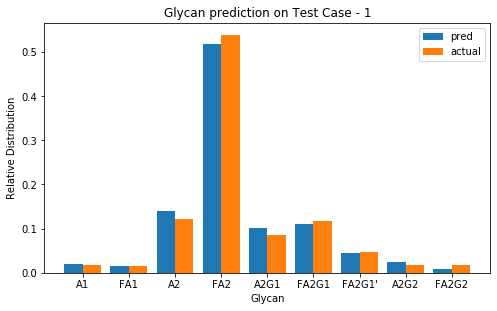

In [3]:
#normal output
Exp1 = mAb_Experiment(7,4,False,'static','normal',True,Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,Outputs_glycan=myOutputs)

0.9918787946258364


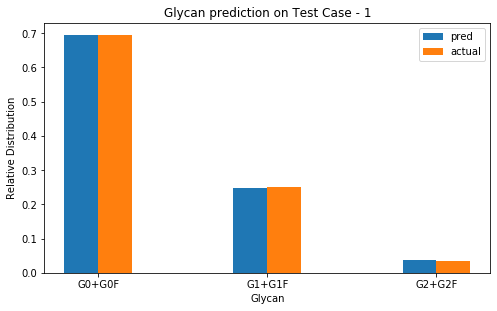

In [4]:
#grouped output
Exp2 = mAb_Experiment(7,4,False,'static','grouped',True,Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,Outputs_glycan=myOutputsGrp)

0.9879392556445007


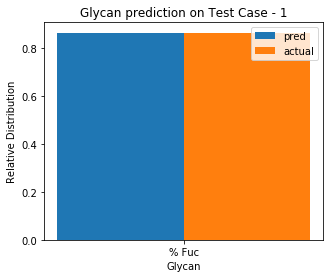

In [5]:
#fuc output
Exp3 = mAb_Experiment(7,4,False,'static','fucose',True,Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG,Outputs_glycan=myOutputsFuc)

0.0010909659497951253


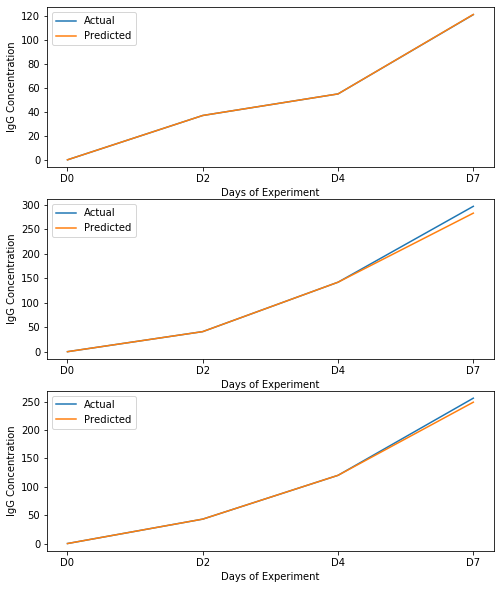

In [6]:
#dynamic output
Exp4 = mAb_Experiment(7,3,False,'dynamic','antibody',True,TCD.iloc[:,:3],VCD.iloc[:,:3],Glucose.iloc[:,:3],
           Glutamine.iloc[:,:3],
           Lactate.iloc[:,:3],Ammonia.iloc[:,:3],IgG.iloc[:,:3],Outputs_antibody=IgG.iloc[:,-1])

0.0021946122392365176


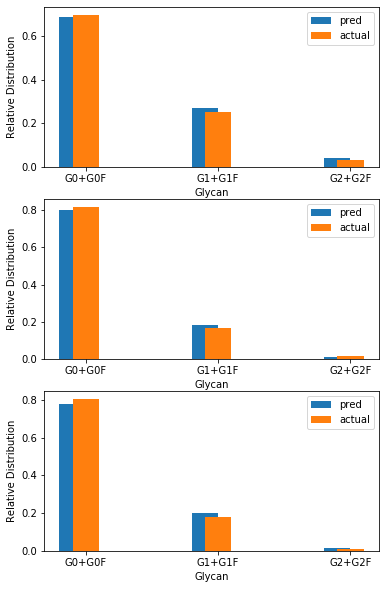

In [7]:
#combined
Exp5 = mAb_Experiment(7,3,False,'combined','grouped',True,TCD.iloc[:,:3],VCD.iloc[:,:3],Glucose.iloc[:,:3],
           Glutamine.iloc[:,:3],Lactate.iloc[:,:3],Ammonia.iloc[:,:3],IgG.iloc[:,:3],Outputs_antibody=IgG.iloc[:,-1],Outputs_glycan=myOutputsGrp)